# Lithology Prediction

### Raw Data Exploration

* Show head (6 rows) of raw data
* Color map of lithology over longitude and latitude
* Histogram of lithology
* Missing part visualization

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

% matplotlib inline

dfdata = pd.read_csv("data/train_clean.csv")
dfdata.head()

,longitude,latitude,lithology,bathymetry,nitrate,oxygen,phosphate,productivity,salinity,silicate,temperature
0,-180,75,4,-231.0,NaN,8.552258,NaN,310.199677,31.165499,NaN,-0.878415
1,-179,75,4,-203.0,1.702168,9.494461,0.754516,312.468658,29.931450,12.485500,-1.785413
2,-178,75,4,-304.0,1.850258,9.578869,0.735949,291.436279,30.048571,12.902109,-1.904204
3,-177,75,4,-278.0,1.960688,9.668440,0.720070,277.305817,30.211161,13.251008,-1.869162
4,-176,75,4,-247.0,2.056301,9.763065,0.706926,262.947571,30.398439,13.591722,-1.688048


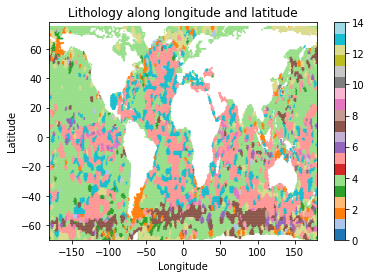

In [2]:
lon = dfdata["longitude"].values
lat = dfdata["latitude"].values
y = dfdata["lithology"].values

# plot lithology vesus longitude and latitude
def draw_global(lon, lat, y, title, cmap="tab20", vmin=0, vmax=14):
    sc = plt.scatter(lon, lat, s=0.5, c=y, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.title(title)
    plt.xlim([-180, 180])
    plt.ylim([-70, 78])
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.colorbar(sc)
    plt.show()
draw_global(lon, lat, y, "Lithology along longitude and latitude")

### Imbalanced Multiclass Classification
As we can see from the histogram of target lithology, the class distribution is not uniform. Some classes have large amount of samples whereas some classes have less samples. This enables model to cost less to predict those rare classes wrong. To fix this problem, we need to re-weight classes to obtain balanced classes.

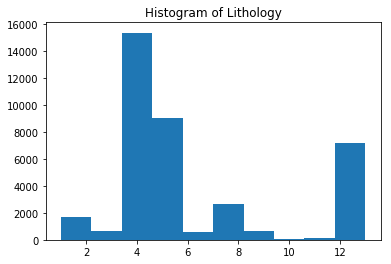

In [3]:
def draw_hist(y, title):
    # plot the histogram of lithology
    plt.hist(y)
    plt.title(title)
    plt.show()

draw_hist(y, "Histogram of Lithology")

In [4]:
training_data = dfdata.copy()

# obtain list of feature names
target = "lithology"
features = list(training_data.columns)
features.remove(target)
features.remove("longitude")
features.remove("latitude")

# impute missing with mean
fill_dict = {}
for col in training_data:
    fill_dict[col] = np.mean(training_data[col])
training_data = training_data.fillna(value=fill_dict)

### Keras - Neural Network Classification

We will deploy keras - a neural network library which is capable for running on top of Tensorflow.
The neural network has the following structure:

- Input layer
- Hidden layer 1: consists of 64 nerons
- Dropout layer : drop out 20% nerons to avoid overfitting
- Hidden layer 2: consists of 64 nerons
- Dropout layer : drop out 20% nerons to avoid overfitting
- Hidden layer 3: consists of 32 nerons
- Dropout layer : drop out 20% nerons to avoid overfitting
- Output layer

In [5]:
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.callbacks import History
from keras.wrappers.scikit_learn import KerasClassifier
from keras import regularizers
from keras.utils import np_utils
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.utils import class_weight

Using Theano backend.


In [6]:
# fix random seed for reproducibility
seed = 0
np.random.seed(seed)
X = training_data[features].astype(float)
Y = training_data[target]

# standardize X
scaler = StandardScaler()
X = scaler.fit_transform(X)

# onehot target Y -> convert integers to dummy variables
encoder = LabelEncoder()
Y = encoder.fit_transform(Y)
dummy_Y = np_utils.to_categorical(Y)

# define baseline model
def baseline_model():
    activation = "relu"
    dropout_ratio = 0.1
    initializer = "random_uniform"
    numclass = dummy_Y.shape[1]
    model = Sequential()
    model.add(Dense(64, input_dim=X.shape[1], activation=activation, kernel_initializer=initializer))
#     model.add(Dropout(rate=dropout_ratio))
    model.add(Dense(64, activation=activation, kernel_initializer=initializer))
#     model.add(Dropout(rate=dropout_ratio))
    model.add(Dense(32, activation=activation, kernel_initializer=initializer))
#     model.add(Dropout(rate=dropout_ratio))
    model.add(Dense(numclass, activation="softmax", kernel_initializer=initializer))
    # compile
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

# class reweighting for imbalanced class
weight = class_weight.compute_class_weight('balanced', np.unique(Y), Y)

# training -> cross validation
estimator = KerasClassifier(build_fn=baseline_model, epochs=200, batch_size=5, verbose=True,
                           class_weight=weight)
kfold = KFold(n_splits=3, shuffle=True, random_state=seed)
results = cross_val_predict(estimator, X, dummy_Y, cv=kfold)

d:\software\anaconda\envs\tensorflow\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
WARNING (theano.gof.compilelock): Overriding existing lock by dead process '15164' (I am process '7924')


Epoch 1/200
25366/25366 [==============================] - 2s 84us/step - loss: 1.5273 - acc: 0.4742
Epoch 2/200
25366/25366 [==============================] - 2s 85us/step - loss: 1.4107 - acc: 0.5136
Epoch 3/200
25366/25366 [==============================] - 2s 85us/step - loss: 1.3682 - acc: 0.5322
Epoch 4/200
25366/25366 [==============================] - 2s 87us/step - loss: 1.3478 - acc: 0.5384
Epoch 5/200
25366/25366 [==============================] - 2s 86us/step - loss: 1.3350 - acc: 0.5424
Epoch 6/200
25366/25366 [==============================] - 2s 86us/step - loss: 1.3217 - acc: 0.5434
Epoch 7/200
25366/25366 [==============================] - 2s 87us/step - loss: 1.3089 - acc: 0.5492
Epoch 8/200
25366/25366 [==============================] - 2s 86us/step - loss: 1.2967 - acc: 0.5507
Epoch 9/200
25366/25366 [==============================] - 2s 86us/step - loss: 1.2840 - acc: 0.5536
Epoch 10/200
25366/25366 [==============================] - 2s 86us/step - loss: 1.2720 - a

25366/25366 [==============================] - 2s 92us/step - loss: 0.9857 - acc: 0.6369
Epoch 82/200
25366/25366 [==============================] - 2s 91us/step - loss: 0.9880 - acc: 0.6340
Epoch 83/200
25366/25366 [==============================] - 2s 91us/step - loss: 0.9858 - acc: 0.6343
Epoch 84/200
25366/25366 [==============================] - 2s 91us/step - loss: 0.9844 - acc: 0.6374
Epoch 85/200
25366/25366 [==============================] - 2s 91us/step - loss: 0.9869 - acc: 0.6395
Epoch 86/200
25366/25366 [==============================] - 2s 91us/step - loss: 0.9818 - acc: 0.6366
Epoch 87/200
25366/25366 [==============================] - 2s 92us/step - loss: 0.9786 - acc: 0.6407
Epoch 88/200
25366/25366 [==============================] - 2s 90us/step - loss: 0.9811 - acc: 0.6371: 0s - loss: 0.98
Epoch 89/200
25366/25366 [==============================] - 2s 92us/step - loss: 0.9792 - acc: 0.6367
Epoch 90/200
25366/25366 [==============================] - 2s 92us/step - los

25366/25366 [==============================] - 2s 91us/step - loss: 0.9081 - acc: 0.6636
Epoch 161/200
25366/25366 [==============================] - 2s 91us/step - loss: 0.9081 - acc: 0.6645
Epoch 162/200
25366/25366 [==============================] - 2s 91us/step - loss: 0.9054 - acc: 0.6651
Epoch 163/200
25366/25366 [==============================] - 2s 91us/step - loss: 0.9056 - acc: 0.6667
Epoch 164/200
25366/25366 [==============================] - 2s 91us/step - loss: 0.9059 - acc: 0.6660
Epoch 165/200
25366/25366 [==============================] - 2s 91us/step - loss: 0.9060 - acc: 0.6658
Epoch 166/200
25366/25366 [==============================] - 2s 91us/step - loss: 0.9055 - acc: 0.6638
Epoch 167/200
25366/25366 [==============================] - 2s 92us/step - loss: 0.9031 - acc: 0.6656
Epoch 168/200
25366/25366 [==============================] - 2s 92us/step - loss: 0.9033 - acc: 0.6680
Epoch 169/200
25366/25366 [==============================] - 2s 92us/step - loss: 0.902

d:\software\anaconda\envs\tensorflow\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Epoch 1/200
25366/25366 [==============================] - 2s 78us/step - loss: 1.5004 - acc: 0.4757
Epoch 2/200
25366/25366 [==============================] - 2s 81us/step - loss: 1.3871 - acc: 0.5223
Epoch 3/200
25366/25366 [==============================] - 2s 82us/step - loss: 1.3566 - acc: 0.5342
Epoch 4/200
25366/25366 [==============================] - 2s 82us/step - loss: 1.3380 - acc: 0.5384
Epoch 5/200
25366/25366 [==============================] - 2s 82us/step - loss: 1.3236 - acc: 0.5435
Epoch 6/200
25366/25366 [==============================] - 2s 83us/step - loss: 1.3080 - acc: 0.5479
Epoch 7/200
25366/25366 [==============================] - 2s 83us/step - loss: 1.2958 - acc: 0.5513
Epoch 8/200
25366/25366 [==============================] - 2s 83us/step - loss: 1.2842 - acc: 0.5538
Epoch 9/200
25366/25366 [==============================] - 2s 83us/step - loss: 1.2728 - acc: 0.5559
Epoch 10/200
25366/25366 [==============================] - 2s 83us/step - loss: 1.2617 - a

25366/25366 [==============================] - 2s 85us/step - loss: 0.9512 - acc: 0.6502
Epoch 82/200
25366/25366 [==============================] - 2s 86us/step - loss: 0.9498 - acc: 0.6510
Epoch 83/200
25366/25366 [==============================] - 2s 86us/step - loss: 0.9526 - acc: 0.6482
Epoch 84/200
25366/25366 [==============================] - 2s 86us/step - loss: 0.9473 - acc: 0.6517
Epoch 85/200
25366/25366 [==============================] - 2s 86us/step - loss: 0.9466 - acc: 0.6518
Epoch 86/200
25366/25366 [==============================] - 2s 86us/step - loss: 0.9438 - acc: 0.6530
Epoch 87/200
25366/25366 [==============================] - 2s 86us/step - loss: 0.9439 - acc: 0.6532
Epoch 88/200
25366/25366 [==============================] - 2s 86us/step - loss: 0.9409 - acc: 0.6538
Epoch 89/200
25366/25366 [==============================] - 2s 86us/step - loss: 0.9379 - acc: 0.6559
Epoch 90/200
25366/25366 [==============================] - 2s 85us/step - loss: 0.9384 - acc: 

25366/25366 [==============================] - 2s 84us/step - loss: 0.8702 - acc: 0.6810
Epoch 161/200
25366/25366 [==============================] - 2s 84us/step - loss: 0.8701 - acc: 0.6766
Epoch 162/200
25366/25366 [==============================] - 2s 83us/step - loss: 0.8687 - acc: 0.6802
Epoch 163/200
25366/25366 [==============================] - 2s 84us/step - loss: 0.8652 - acc: 0.6790
Epoch 164/200
25366/25366 [==============================] - 2s 84us/step - loss: 0.8680 - acc: 0.6791
Epoch 165/200
25366/25366 [==============================] - 2s 84us/step - loss: 0.8663 - acc: 0.6783
Epoch 166/200
25366/25366 [==============================] - 2s 83us/step - loss: 0.8642 - acc: 0.6792
Epoch 167/200
25366/25366 [==============================] - 2s 83us/step - loss: 0.8647 - acc: 0.6811
Epoch 168/200
25366/25366 [==============================] - 2s 84us/step - loss: 0.8632 - acc: 0.6801
Epoch 169/200
25366/25366 [==============================] - 2s 84us/step - loss: 0.862

d:\software\anaconda\envs\tensorflow\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Epoch 1/200
25366/25366 [==============================] - 2s 74us/step - loss: 1.4855 - acc: 0.4887
Epoch 2/200
25366/25366 [==============================] - 2s 77us/step - loss: 1.3826 - acc: 0.5211
Epoch 3/200
25366/25366 [==============================] - 2s 77us/step - loss: 1.3536 - acc: 0.5334
Epoch 4/200
25366/25366 [==============================] - 2s 76us/step - loss: 1.3359 - acc: 0.5419
Epoch 5/200
25366/25366 [==============================] - 2s 76us/step - loss: 1.3194 - acc: 0.5448
Epoch 6/200
25366/25366 [==============================] - 2s 76us/step - loss: 1.3048 - acc: 0.5519
Epoch 7/200
25366/25366 [==============================] - 2s 77us/step - loss: 1.2898 - acc: 0.5549
Epoch 8/200
25366/25366 [==============================] - 2s 76us/step - loss: 1.2786 - acc: 0.5563
Epoch 9/200
25366/25366 [==============================] - 2s 75us/step - loss: 1.2656 - acc: 0.5561
Epoch 10/200
25366/25366 [==============================] - 2s 76us/step - loss: 1.2574 - a

25366/25366 [==============================] - 2s 80us/step - loss: 0.9412 - acc: 0.6532
Epoch 81/200
25366/25366 [==============================] - 2s 80us/step - loss: 0.9415 - acc: 0.6527
Epoch 82/200
25366/25366 [==============================] - 2s 80us/step - loss: 0.9362 - acc: 0.6563
Epoch 83/200
25366/25366 [==============================] - 2s 80us/step - loss: 0.9349 - acc: 0.6561
Epoch 84/200
25366/25366 [==============================] - 2s 80us/step - loss: 0.9334 - acc: 0.6571
Epoch 85/200
25366/25366 [==============================] - 2s 80us/step - loss: 0.9325 - acc: 0.6581
Epoch 86/200
25366/25366 [==============================] - 2s 80us/step - loss: 0.9295 - acc: 0.6572
Epoch 87/200
25366/25366 [==============================] - 2s 80us/step - loss: 0.9335 - acc: 0.6557
Epoch 88/200
25366/25366 [==============================] - 2s 80us/step - loss: 0.9280 - acc: 0.6578
Epoch 89/200
25366/25366 [==============================] - 2s 79us/step - loss: 0.9296 - acc: 

25366/25366 [==============================] - 2s 79us/step - loss: 0.8573 - acc: 0.6838
Epoch 160/200
25366/25366 [==============================] - 2s 80us/step - loss: 0.8555 - acc: 0.6828
Epoch 161/200
25366/25366 [==============================] - 2s 80us/step - loss: 0.8532 - acc: 0.6834
Epoch 162/200
25366/25366 [==============================] - 2s 80us/step - loss: 0.8501 - acc: 0.6825
Epoch 163/200
25366/25366 [==============================] - 2s 80us/step - loss: 0.8543 - acc: 0.6826
Epoch 164/200
25366/25366 [==============================] - 2s 80us/step - loss: 0.8478 - acc: 0.6849
Epoch 165/200
25366/25366 [==============================] - 2s 80us/step - loss: 0.8519 - acc: 0.6834
Epoch 166/200
25366/25366 [==============================] - 2s 80us/step - loss: 0.8497 - acc: 0.6824
Epoch 167/200
25366/25366 [==============================] - 2s 80us/step - loss: 0.8531 - acc: 0.6837
Epoch 168/200
25366/25366 [==============================] - 2s 80us/step - loss: 0.848

Accuracy = 0.6338142920970328


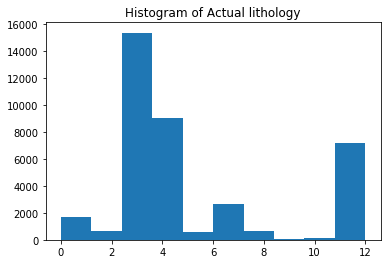

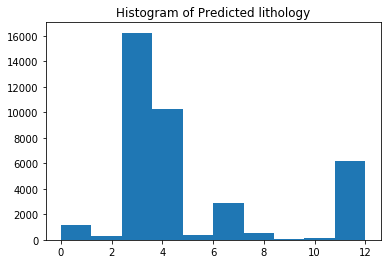

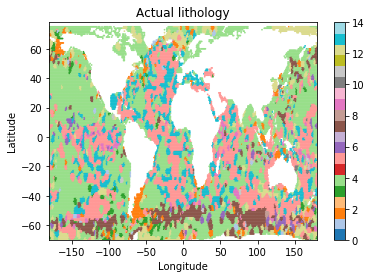

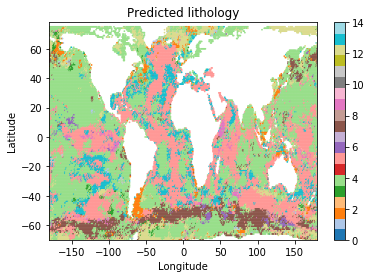

In [7]:
print("Accuracy = {}".format(accuracy_score(Y, results)))
draw_hist(Y, "Histogram of Actual lithology")
draw_hist(results, "Histogram of Predicted lithology")
draw_global(lon, lat, y, "Actual lithology")
draw_global(lon, lat, results + 1, "Predicted lithology")